In [1]:
cd ../..

/lfs/rambo/0/adobles/relbench-user-study


/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Feature Ideas

- `week_of_year`
- `month_of_year`
- `day_of_month`
- `day_of_week`
- `customer_age`
- `fn_not_null`: Whether the FN customer field is null
- `customer_is_active`
- `club_member_status`
- `fashion_news_frequency`
- Customer aggs full history:
    - `total_purchase_count`
    - `total_purchase_amount`
    - `avg_purchase_price`
    - `total_unique_articles_purchased`
    - `prop_sales_channel_2`
    - `modal_dept_no`
    - `modal_section_no`
    - `modal_color_id`
- For each of the past 5 weeks:
    - `num_purchases`
    - `purchased_amount`
    - `avg_purchase_price`
    - `num_unique_articles_purchased`
    - `prop_sales_channel_2`
    - Aggs over items customer purchased in that period:
        - `avg_monthly_sales_amount`
        - `avg_monthly_sales_count`
        - `avg_days_since_last_sale`
        - `modal_dept_no`
        - `modal_section_no`
        - `modal_color_id`

In [3]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('hm/hm.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

In [53]:
with open('hm/churn/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=0))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [4]:
utils.validate_feature_tables('churn', conn)

Validating train
train labels size: 3,871,410 x 3
train feats size: 3,871,410 x 74

Validating val
val labels size: 76,556 x 3
val feats size: 76,556 x 74

Validating test
test labels size: 74,575 x 2
test feats size: 74,575 x 73

✅ All tables are valid!


In [5]:
%%sql train_df <<
from churn_train_feats

In [6]:
infer_df_stype(train_df)

{'customer_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'churn': <stype.categorical: 'categorical'>,
 'week_of_year': <stype.categorical: 'categorical'>,
 'month_of_year': <stype.categorical: 'categorical'>,
 'day_of_month': <stype.categorical: 'categorical'>,
 'age': <stype.categorical: 'categorical'>,
 'fn_not_null': <stype.categorical: 'categorical'>,
 'is_active': <stype.categorical: 'categorical'>,
 'club_member_status': <stype.categorical: 'categorical'>,
 'fashion_news_frequency': <stype.text_embedded: 'text_embedded'>,
 'total_purchase_count': <stype.numerical: 'numerical'>,
 'total_purchase_amount': <stype.numerical: 'numerical'>,
 'avg_purchase_price': <stype.numerical: 'numerical'>,
 'total_unique_articles_purchased': <stype.numerical: 'numerical'>,
 'prop_sales_channel_2': <stype.numerical: 'numerical'>,
 'modal_dept_no': <stype.numerical: 'numerical'>,
 'modal_section_no': <stype.numerical: 'numerical'>,
 'modal_color_id': <stype.nume

In [8]:
utils.feature_summary_df(train_df.sample(20_000), 'churn', classification=True)

,Label Corr.,Label MI,NaN %
total_purchase_amount,-0.209,0.027,1.4%
total_purchase_count,-0.219,0.026,1.4%
total_unique_articles_purchased,-0.222,0.025,1.4%
avg_purchase_price_3_weeks_ago,-0.010,0.016,84.0%
num_purchases_3_weeks_ago,-0.088,0.015,0.0%
avg_purchase_price_2_weeks_ago,-0.008,0.014,82.6%
prop_sales_channel_2_4_weeks_ago,-0.024,0.013,83.9%
purchased_amount_4_weeks_ago,-0.083,0.013,83.9%
avg_days_since_last_sale_4_weeks_ago,0.011,0.013,84.0%
num_unique_articles_purchased_4_weeks_ago,-0.123,0.013,0.0%


## Feature Importances

In [16]:
import numpy as np
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-hm-user-churn'

task_params = TASK_PARAMS[TASK]

In [10]:
%%sql val_df <<
select * from churn_val_feats;

In [11]:
val_tf = Dataset(
    val_df,
    col_to_stype=task_to_stypes[TASK],
    target_col=task_params['target_col'],
).materialize().tensor_frame

In [12]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


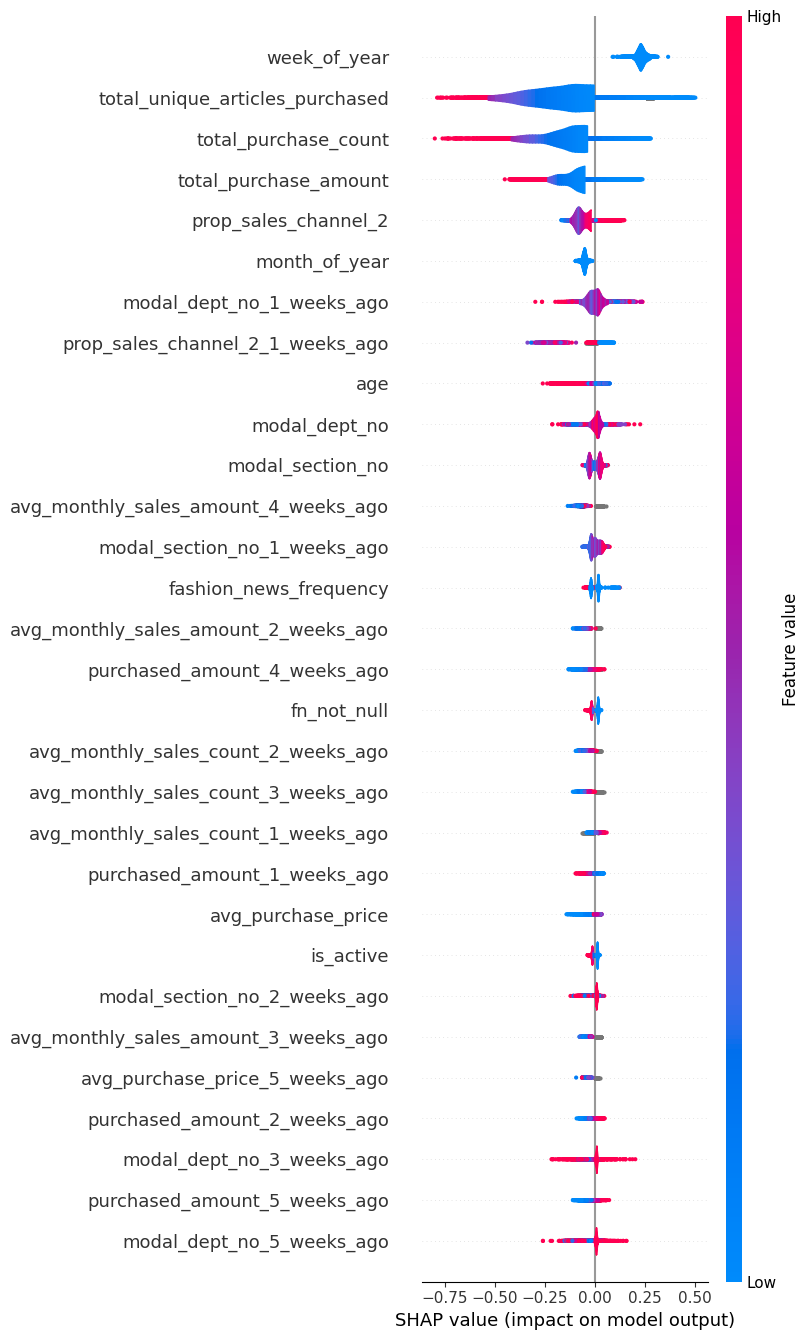

In [17]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

sample = np.random.randint(0, len(val_tf), size=10_000)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[sample])
shap_values = explainer.shap_values(val_arr, pred[sample])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

In [16]:
conn.close()